# Including

In [2]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations;
using LinearAlgebra
#@nbinclude("Hofstadter Single Particle in Julia.ipynb"; regex=r"#.*executeme")
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb");

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [65]:
Nx=7
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = Nx
PN = [0, 1, 2, 3]
U = 1;

# Sub Space Kinetic Term

In [66]:
function H_sp(N, Nx, Ny, p, q)
    sp_basis = NLevelBasis(N)
    periodicity = 0 #periodic (select 1 for hard-wall conditions)
    sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity)
    H1 = get_sp_op(sp_basis, sp_matrix)
    return H1, sp_basis
end

H_sp (generic function with 1 method)

In [67]:
H1, sp_basis = H_sp(N, Nx, Ny, p, q);

In [68]:
function H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    return H1_sub, basis_sub, P, Pt
end

H_sub (generic function with 1 method)

In [69]:
H1_sub, basis_sub, P, Pt = H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis);

In [70]:
function H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    states_mb = bosonstates(basis_sub, PN) 
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, H1_sub)
    return H1_MB
end

H_Kin_MB (generic function with 1 method)

In [71]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [72]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off, PN);

In [73]:
function H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb)
    H_Kin = SparseOperator(basis_cut_mb)
    H1_MB = H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    H_Kin.data = H1_MB.data
    H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U)
    return H_Kin, H_Kin + H_Int
end

H_Total_Sub (generic function with 1 method)

In [74]:
basis_cut_sp

NLevel(N=7)

In [75]:
basis_cut_mb

ManyBody(onebodybasis=NLevel(N=7), states:120)

# Sub Space Hubbard Interaction Term

In [76]:
H_Kin, Total_H = H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb);

0.0%┣                                                ┫ 0/7 [00:00<00:00, -0s/it]
42.9%┣████████████████████▏                          ┫ 3/7 [00:00<00:00, 39it/s]
100.0%┣██████████████████████████████████████████████┫ 7/7 [00:00<00:00, 79it/s]
100.0%┣██████████████████████████████████████████████┫ 7/7 [00:00<00:00, 79it/s]


# Total Hamiltonian with Impurity Potential

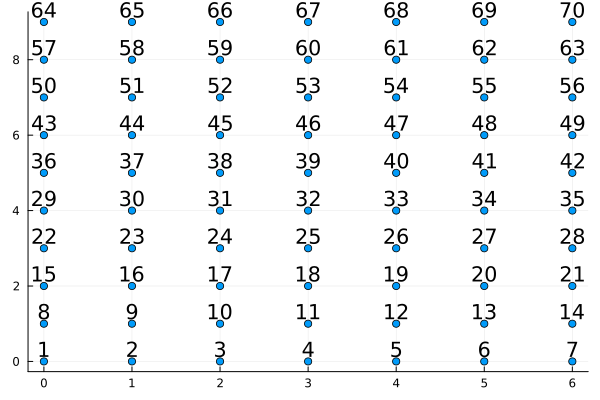

In [77]:
plot_square_lattice(Nx, Ny)

For particle pinning: V0<0 & PN = 1, U = 0!

In [78]:
V0 = [0.1]; Imp_Site = [44]
Impurity_Data = Impurity(V0, Imp_Site);

In [79]:
function Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub)
    num_sub_list = get_num_sub_list(N, sp_basis, P, Pt)
    Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)
    return Sub_Number_MB_Operator_List
end

Number_sub (generic function with 1 method)

In [80]:
Sub_Number_MB_Operator_List = Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub);

0.0%┣                                               ┫ 0/70 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 70/70 [00:00<00:00, 34.3kit/s]
100.0%┣█████████████████████████████████████████┫ 70/70 [00:00<00:00, 33.7kit/s]


In [81]:
function get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = dense((H_Impurity'+H_Impurity)/2);
    return H_Impurity
end

get_H_Impurity (generic function with 1 method)

In [82]:
H_Impurity = get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data);

In [83]:
# SP IMPURITY

In [84]:
# VV = zeros(Nx*Ny,Nx*Ny)
# site = Impurity_Data.Imp_Site[1]
# VV[site, site] = Impurity_Data.V0[1] # full localised single particle
# VV = Operator(sp_basis,sp_basis,VV);

In [85]:
# H_imp_SP = H1 + VV;

In [86]:
# sub_states = get_sub_states(H_imp_SP, cut_off)
# basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
# H_imp_sp_sub = get_subspace_op(H_imp_SP, P, Pt)
# H_imp_sp_sub = (H_imp_sp_sub' + H_imp_sp_sub)/2;

In [87]:
# E_sp_sub, V_sp_sub = eigenstates(H_imp_sp_sub);
# scatter(E_sp_sub)

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [88]:
function ground_degeneracy(N_Pin, nu0, PN)
    NPhi0 = Nx*Ny*(p/q)
    NPhi = NPhi0-N_Pin
    pn = maximum(PN)
    N_d = Int(NPhi - pn/nu0)
    Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
    return Degeneracy
end

ground_degeneracy (generic function with 1 method)

In [89]:
if length(PN) != 1
    nu0 = 1/2
    N_Pin = 1
    Degeneracy = ground_degeneracy(N_Pin, nu0, PN)
else
    Degeneracy = 1
end

2

In [90]:
function energies_imp(H_Impurity, PN, basis_cut_mb)
    E, V = eigenstates(H_Impurity)
    pn = maximum(PN)
    filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb)
    return filtered_energies, V
end

energies_imp (generic function with 1 method)

In [91]:
# PN = 1 İken (AB faz hesaplarken) sadece bir parçacık var o yüzden filter yapmayacağız!!!

In [92]:
filtered_energies, V = energies_imp(H_Impurity, PN, basis_cut_mb);

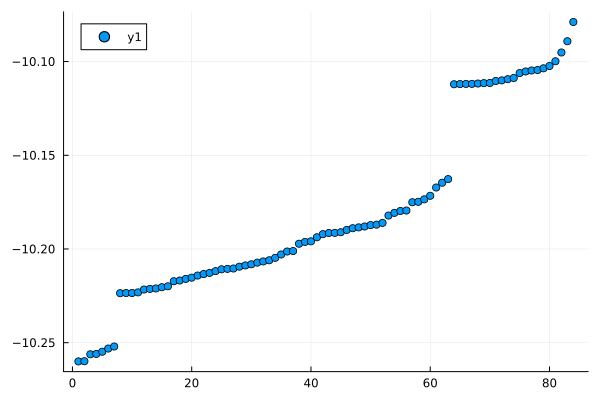

In [93]:
scatter(filtered_energies)

In [94]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

# Density Profile

In [95]:
filtered_energies;

In [96]:
r_hubbard_states = Restricted_Hubbard_States(V, filtered_energies);

In [97]:
function plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
    avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)
    return Plots.heatmap(Interp(avg_density', factor), aspect_ratio=:equal)
end

plot_density (generic function with 1 method)

In [98]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

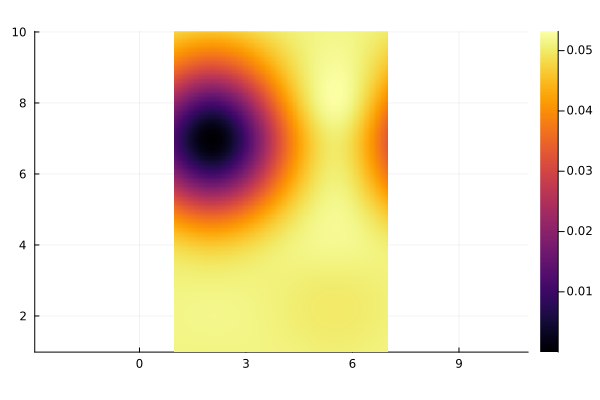

In [99]:
factor = 25
plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

In [100]:
# plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, V_sp_sub, factor)

# Torus Distance and Equivalent (Periodic) Sites

In [101]:
@nbinclude("Torus_Distance.ipynb");

In [102]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 36 # Site Pinned (Site 44 = Site 36) # BURASI GENEL DEĞİL SORUN YARATABİLİR!!!
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [103]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

# Density Plot and $Q_{\rho}$ Calculation

In [104]:
# # Density Plot
# index_eig_states = 1
# Plots.heatmap(Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)', colormap=:dense)

# # koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
# x_coordinates = coordinates[:,1] .+1
# y_coordinates = coordinates[:,2] .+1
# Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# # Site Index
# for i in 1:N
#     p = Plots.annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
# end

# # Circle
# function circle_shape(h,k,r)
#     beta = reverse(LinRange(0, 2*pi, 500))
#     h .+ r*sin.(beta), k .+ r*cos.(beta)
# end

# # Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
# center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1
# Plots.plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

# p

In [105]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

In [106]:
radius_list

17-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 5.0
 5.0990195135927845
 5.385164807134504
 5.830951894845301

In [107]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [108]:
pn = maximum(PN)
NPhi0 = Nx*Ny*(p/q)
NPhi = NPhi0-N_Pin
pn = maximum(PN)
N_d = Int(NPhi - pn/nu0)

0

In [109]:
depletion_prof = get_depletion_profile(radius_list, avg_density)

17-element Vector{Any}:
 0.0128270338980713
 0.06554701884533792
 0.11843515950344398
 0.16932454719393847
 0.2662987544722787
 0.30536805603722805
 0.35193848474063605
 0.43587730110020717
 0.49322789909329784
 0.4922683933403712
 0.4916085679530278
 0.5075665200115834
 0.5082197256206985
 0.5047956932528063
 0.5047956932528063
 0.5026451615842638
 0.5000000000000009

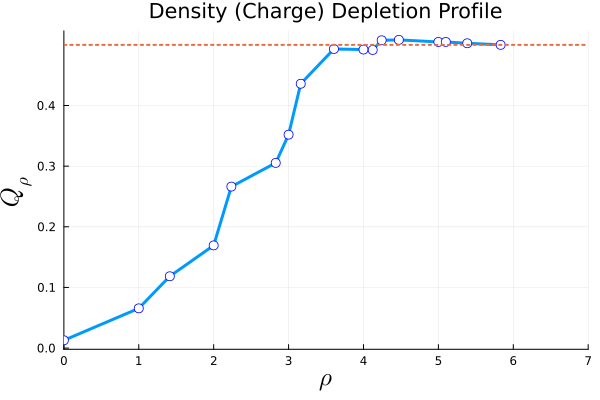

In [110]:
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
Q = pn/NPhi
g(x)=Q; x=0
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

# Braiding and AB Phase Calculations

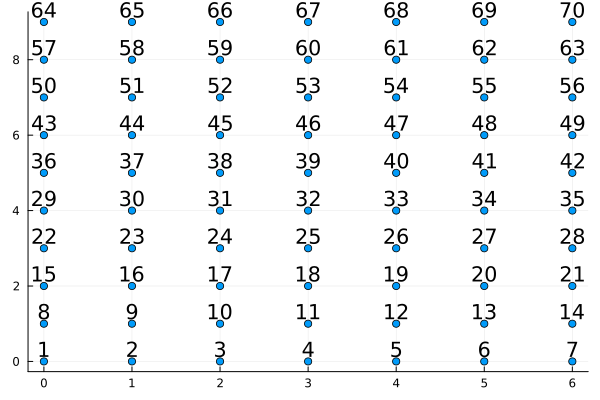

In [111]:
plot_square_lattice(Nx, Ny)

In [116]:
start_point_1 = 17
#start_point_1 = Impurity_Data.Imp_Site[1]

17

In [117]:
lens_1 = [2, 5, 2, 5]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))

14-element Vector{Int64}:
 17
 18
 19
 26
 33
 40
 47
 54
 53
 52
 45
 38
 31
 24

In [118]:
#start_point_2 = Impurity_Data.Imp_Site[2]
start_point_2 = 5

5

In [119]:
lens_2 = [4, 8]
dirs_2 = [-1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2=rec_path_1

14-element Vector{Int64}:
 17
 18
 19
 26
 33
 40
 47
 54
 53
 52
 45
 38
 31
 24

In [120]:
N_Pin = 4
V1 = Impurity_Data.V0[1]
V2 = 0;
#V2 = Impurity_Data.V0[2]

In [121]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site);

In [122]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [123]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...);

In [124]:
U_first = copy(U_Imp_0);

In [152]:
delta_t = 0.0015
STEP = 0:delta_t:1
length(STEP)

667

In [153]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [154]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [155]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                            ┫ 0/8.7k [00:00<-1:-41, -0s/it]
2.6%┣█                                        ┫ 229/8.7k [00:00<00:02, 3.7kit/s]
9.8%┣████                                     ┫ 849/8.7k [00:00<00:01, 7.6kit/s]
16.7%┣██████▌                                ┫ 1.5k/8.7k [00:00<00:01, 8.9kit/s]
22.8%┣█████████                              ┫ 2.0k/8.7k [00:00<00:01, 9.3kit/s]
28.7%┣███████████▏                           ┫ 2.5k/8.7k [00:00<00:01, 9.5kit/s]
34.9%┣█████████████▋                         ┫ 3.0k/8.7k [00:00<00:01, 9.7kit/s]
41.2%┣████████████████                       ┫ 3.6k/8.7k [00:00<00:01, 9.8kit/s]
47.4%┣██████████████████▌                    ┫ 4.1k/8.7k [00:00<00:00, 9.9kit/s]
53.3%┣████████████████████▉                  ┫ 4.6k/8.7k [00:00<00:00, 9.9kit/s]
59.5%┣██████████████████████▋               ┫ 5.2k/8.7k [00:01<00:00, 10.0kit/s]
65.4%┣████████████████████████▉             ┫ 5.7k/8.7k [00:01<00:00, 10.0kit/s]
71.6%┣██████████████████████

In [156]:
function U_Imp_0_Ket()
    Eigen_List = []
    U_IMP_0_List = []
    for Impurity_HH in ProgressBar(Impurity_H_List)
        Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
        E_Imp, U_Imp = eigenstates(Impurity_HH)
        push!(Eigen_List, U_Imp)
        U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
        A = U_Imp_0'*U_Imp
        A_inv = inv(A)
        U_Imp_0 = U_Imp*transpose(A_inv)
        global U_Imp_0 = gram_schmidt(U_Imp_0)
    end
    return U_Imp_0, Eigen_List, U_IMP_0_List
end

U_Imp_0_Ket (generic function with 1 method)

In [157]:
U_Imp_0, Eigen_List, U_IMP_0_List = U_Imp_0_Ket();

0.0%┣                                             ┫ 0/8.7k [00:00<00:00, -0s/it]
0.1%┣                                           ┫ 11/8.7k [00:00<00:44, 196it/s]
0.4%┣▏                                          ┫ 35/8.7k [00:00<00:26, 327it/s]
0.7%┣▎                                          ┫ 60/8.7k [00:00<00:23, 376it/s]
1.0%┣▍                                          ┫ 87/8.7k [00:00<00:21, 413it/s]
1.3%┣▌                                         ┫ 114/8.7k [00:00<00:20, 435it/s]
1.6%┣▊                                         ┫ 141/8.7k [00:00<00:19, 450it/s]
1.9%┣▉                                         ┫ 168/8.7k [00:00<00:18, 461it/s]
2.2%┣█                                         ┫ 195/8.7k [00:00<00:18, 469it/s]
2.6%┣█                                         ┫ 222/8.7k [00:00<00:18, 475it/s]
2.9%┣█▏                                        ┫ 249/8.7k [00:01<00:18, 480it/s]
3.2%┣█▍                                        ┫ 276/8.7k [00:01<00:17, 484it/s]
3.5%┣█▌                     

In [158]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
angle.(BerryEnergies)/pi

2-element Vector{Float64}:
 -0.7154410376658119
  0.6866341322573748

In [ ]:
(2/10)*(1/2)*(10)

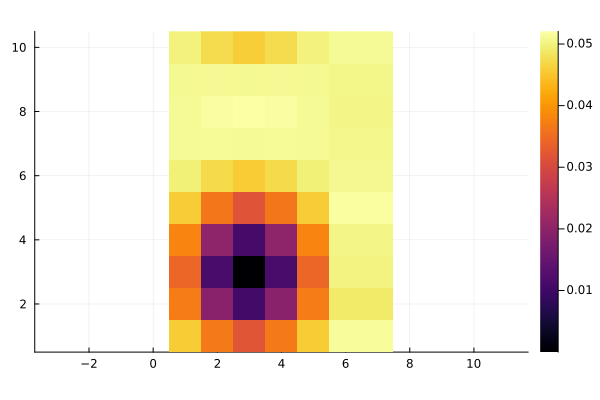

In [485]:
data1 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[1])'
heatmap(Interp(data1, 1), aspect_ratio=:equal)

# Single Particle Brading with Tanh Potential

In [164]:
# Not: Kodun başında ki parametreler SP için OLMALI!

In [145]:
co = vcat( ( [y x] for x in 0:Ny-1 for y in 0:Nx-1 ) ... );

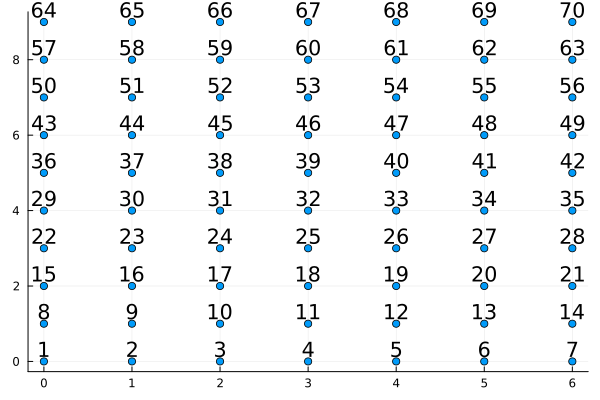

In [146]:
plot_square_lattice(Nx, Ny)

In [151]:
x0, y0 = co[18,:]
x1, y1 = co[20,:]
x2, y2 = co[48,:]
x3, y3 = co[46,:]
coord = [x0, y0, x1, y1, x2, y2, x3, y3];

In [152]:
mutable struct impurity
    V0::Float64
    pos::Array{Float64}
    wid::Float64
end

In [181]:
V0 = 10
wid = 0.1
imps = [impurity(V0, [x0,y0], wid) ];

In [182]:
function Vpin2(imp, N, co)
    VV   = zeros(N,N)
    for site in 1:N
        VV[site, site] = imp.V0*(tanh( norm( co[site,:] - imp.pos ) / imp.wid )^2 -1)
    end
    return VV
end

Vpin2 (generic function with 1 method)

In [183]:
function Vimp2(imps, N, co)
    VM   = zeros(N,N)
    for imp in imps 
        VM +=  Vpin2(imp, N, co)
    end
    return VM
end

Vimp2 (generic function with 1 method)

In [184]:
function Himp(imps, N, co, basis, H1)
    VimpM = Vimp2(imps, N, co)
    Vimp_op = get_sp_op(basis, VimpM)
    return H1 + Vimp_op
end

Himp (generic function with 1 method)

In [185]:
H1_tanh = Himp(imps, N, co, sp_basis, H1);

In [186]:
E_0, U_0 = eigenstates(dense(H1_tanh));

In [187]:
θ, ψ_list = get_ab_phase2(coord, 0.1, V0, wid, N, co, sp_basis, H1, U_0, Degeneracy);

In [188]:
θ

0.577270671745267